In [6]:
import os
import pandas as pd
import numpy as np
import nltk
import praw
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
#from wordcloud import WordCloud, STOPWORDS 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,cross_val_score,train_test_split
from sklearn import tree
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,accuracy_score
import datetime as dt
from bs4 import BeautifulSoup
from sklearn.pipeline import Pipeline

### Flairs considered

In [7]:
flairs=['Food','Politics','Sports','Business/Finance','Scheduled','Coronavirus','Science/Technology','Photography',
        'AMA','Policy/Economy','Non-Political','AskIndia','CAA-NRC-NPR','[R]eddiquette'] 

In [8]:
import warnings
warnings.filterwarnings("ignore")
## Remember to add documentation before sending
from tqdm import tqdm

### Cell below sets up Reddit api to scrap data
1. https://www.storybench.org/how-to-scrape-reddit-with-python/
2. We tried scraping 14k datapoints
3. But we could scrap only 2791 datapoints



### Data Fetching
1. Setup the reddit api
2. Scraps Flair, title, ID, URL, SCORE, Comments
3. If you are hearing the word first time--> It simply means TAGS

In [16]:
# # https://www.storybench.org/how-to-scrape-reddit-with-python/


reddit = praw.Reddit(client_id='enter yours', client_secret='enter yours',
                     user_agent='enter yours', username='enter yours', password='enter yours')

subreddit = reddit.subreddit('india')
topics_dict = {"flair":[], "title":[], "score":[], "id":[], "url":[], "comms_num": [], "created": [], "body":[], "author":[], "comments":[]}


def get_date(created):
    return dt.datetime.fromtimestamp(created)


for flair in tqdm(flairs):
  
  get_subreddits = subreddit.search(flair, limit=1000)
  
  for submission in get_subreddits:
    
    topics_dict["flair"].append(flair)
    topics_dict["title"].append(submission.title)
    topics_dict["score"].append(submission.score)
    topics_dict["id"].append(submission.id)
    topics_dict["url"].append(submission.url)
    topics_dict["comms_num"].append(submission.num_comments)
    topics_dict["created"].append(submission.created)
    topics_dict["body"].append(submission.selftext)
    topics_dict["author"].append(submission.author)
    
    submission.comments.replace_more(limit=None)
    comment = ''
    for top_level_comment in submission.comments:
        comment = comment + ' ' + top_level_comment.body
    topics_dict["comments"].append(comment)
    
topics_data = pd.DataFrame(topics_dict)
# # _timestamp = topics_data["created"].apply(get_date)
# # topics_data = topics_data.assign(timestamp = _timestamp)
# # del topics_data['created']
topics_data.to_csv('reddit-india-data.csv', index=False)

100%|██████████| 14/14 [3:55:53<00:00, 1010.93s/it]  


In [18]:
topics_data.shape
#topics_data

(2791, 10)

In [17]:
topics_data.to_csv('reddit-india-data.csv', index=False)

In [19]:
df=pd.read_csv("reddit-india-data.csv")
df.columns

Index(['flair', 'title', 'score', 'id', 'url', 'comms_num', 'created', 'body',
       'author', 'comments'],
      dtype='object')

In [20]:
df.shape

(2791, 10)

In [21]:
df.head(5)

flair                                              title  score      id  \
0  AskIndia  Am I ruining my career by not going to branded...      8  qb6goc   
1  AskIndia                                  Cant think of one      2  q5sqk3   
2  AskIndia                                    On PraveenMohan      3  prmhc8   
3  AskIndia  Need feedback for Insurance Policy that I took...      1  1s57oi   
4  AskIndia  What is the procedure followed in india if the...     11  ne9e5j   

                                                 url  comms_num       created  \
0  https://www.reddit.com/r/india/comments/qb6goc...          9  1.634629e+09   
1  https://www.reddit.com/r/india/comments/q5sqk3...          3  1.633947e+09   
2  https://www.reddit.com/r/india/comments/prmhc8...         29  1.632108e+09   
3  https://www.reddit.com/r/india/comments/1s57oi...          1  1.386225e+09   
4  https://www.reddit.com/r/india/comments/ne9e5j...          5  1.621236e+09   

                                                body                author  \
0  I know this is not the usual kind of posts you...    ThrowIndianCollege   
1  I was surfing in /AskIndia and saw a lot of pe...             Fruitoash   
2  Okay first of all, Im a fan of Indian Temple a...  Spirited_Chipmunk_48   
3  **Re-posting here because of lack of activity ...         dhavalcoholic   
4  Will the court go on with a trial? Or will the...        cant_bother_me   

                                            comments  
0    See it this way. 5 people are running a 10 k...  
1   how do you know that you are depressed? did a...  
2   Science is dope has debunked him Okay. No. St...  
3   Dear Policy Holder(Dhavalcoholic),\n \nWe req...  
4   Low media support: Case dismissed\n\nHigh med...

In [22]:
df['flair'].value_counts()

Food                  243
Politics              239
Sports                238
Business/Finance      232
Scheduled             228
Coronavirus           227
Science/Technology    223
Photography           221
AMA                   218
Policy/Economy        217
Non-Political         212
AskIndia              187
CAA-NRC-NPR            90
[R]eddiquette          16
Name: flair, dtype: int64

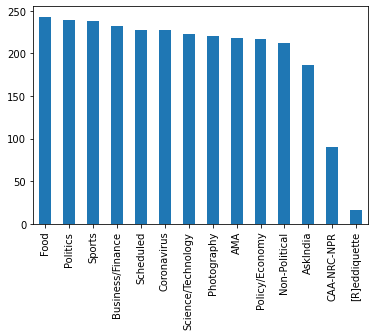

In [23]:
df['flair'].value_counts().plot.bar()
plt.show()

In [24]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", "nan","https", "www", "com" ])

### Cell below plots top 50 words in title

In [28]:
from wordcloud import WordCloud


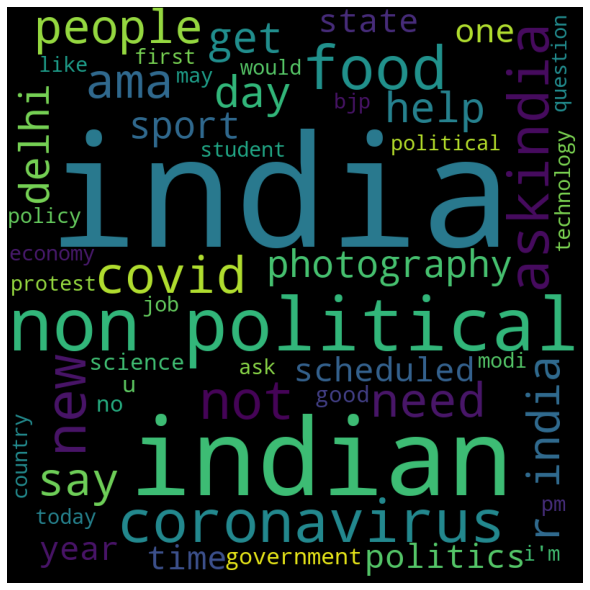

In [29]:
comment_words = '' 
# stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.title: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800,  max_words=50,
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 


### Cell below plots top 150 words in body

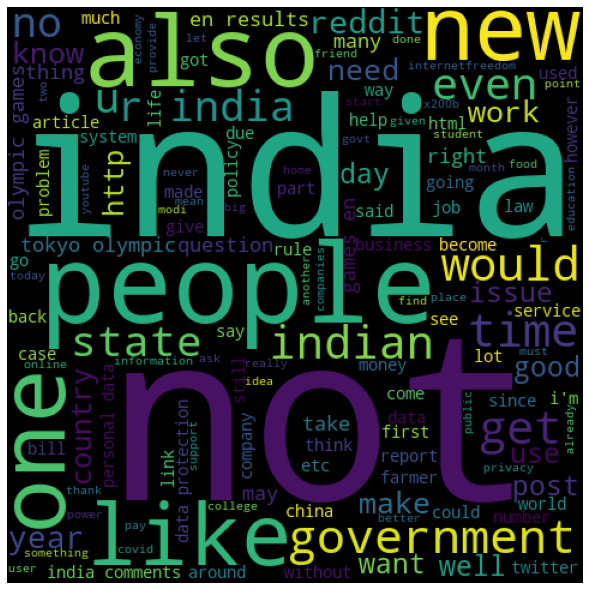

In [30]:
comment_words = '' 
# stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.body: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 480, height = 480,  max_words=150,
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 


### Top Words in Body for different flairs 

For Flair  AskIndia


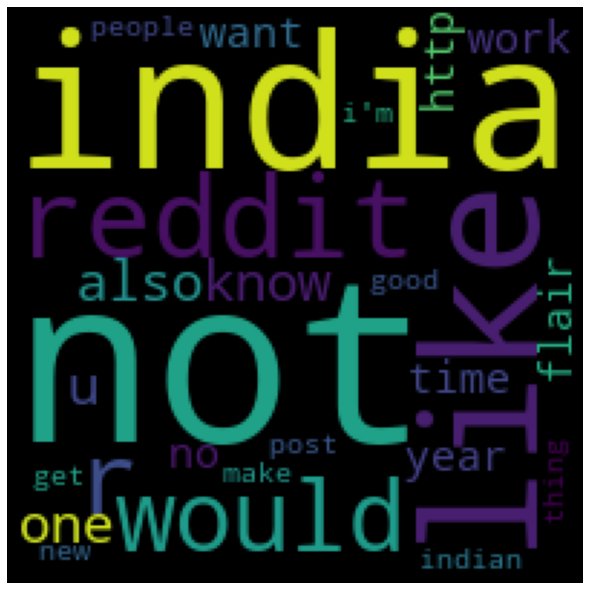

For Flair  Non-Political


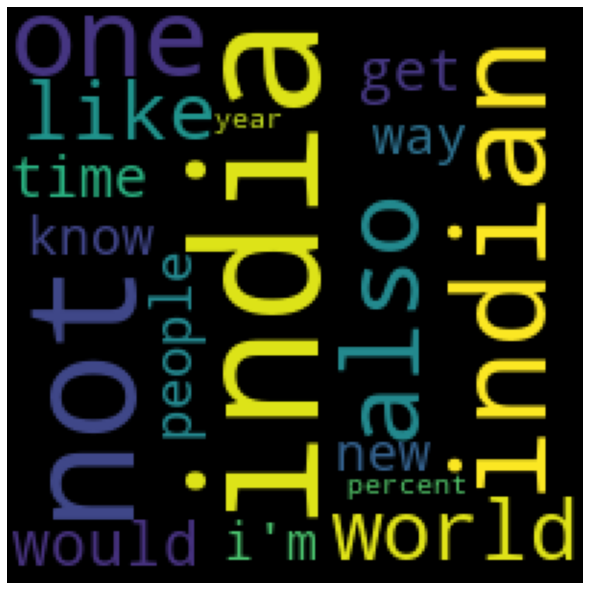

For Flair  [R]eddiquette


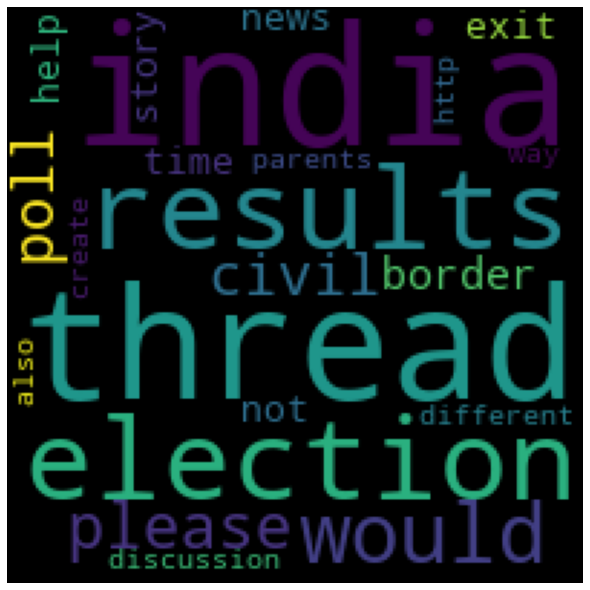

For Flair  Scheduled


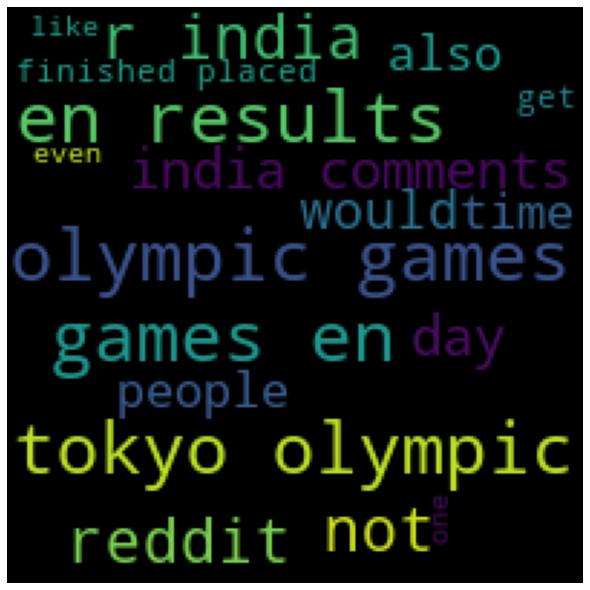

For Flair  Photography


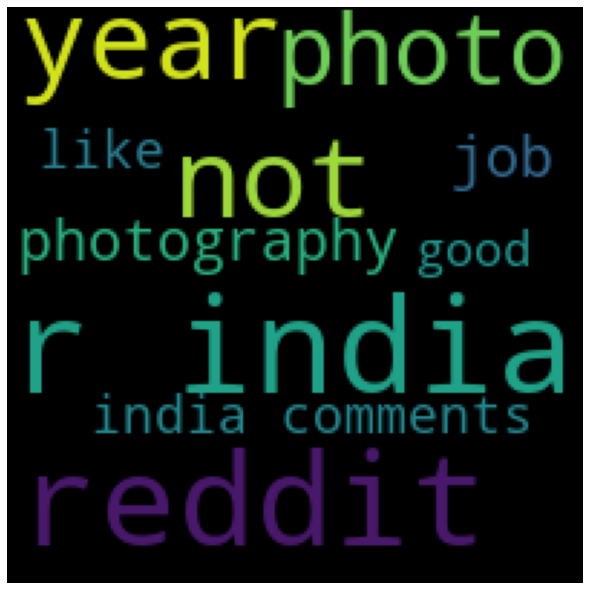

For Flair  Science/Technology


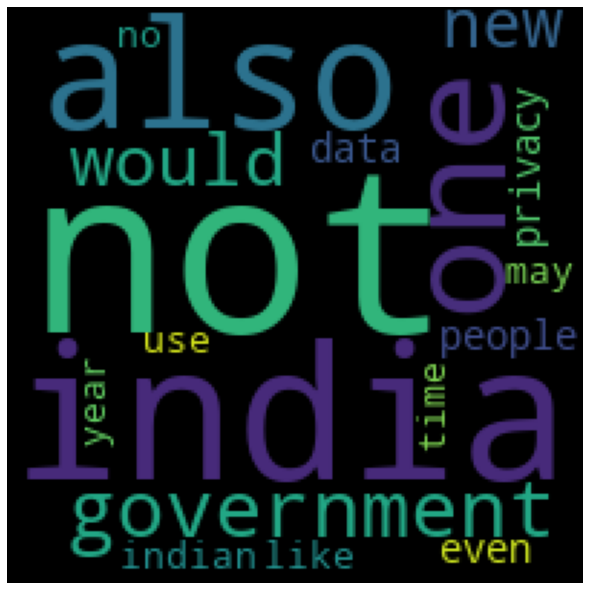

For Flair  Politics


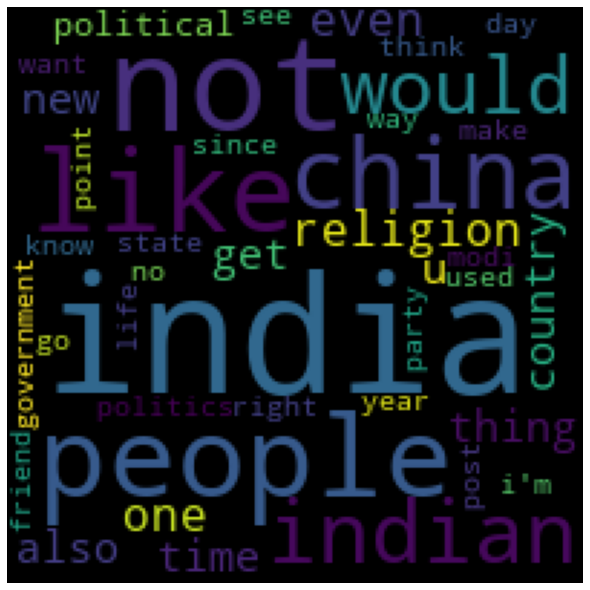

For Flair  Business/Finance


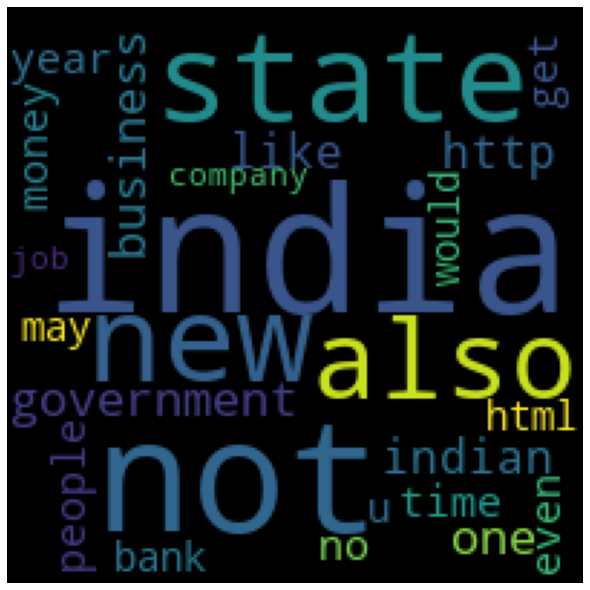

For Flair  Policy/Economy


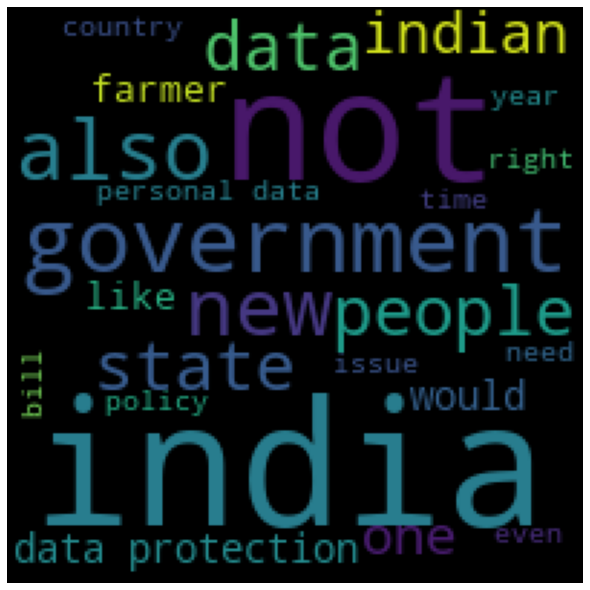

For Flair  Sports


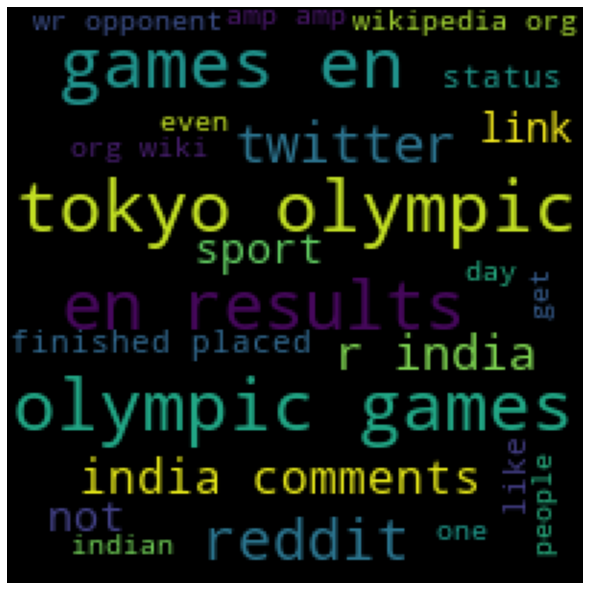

For Flair  Food


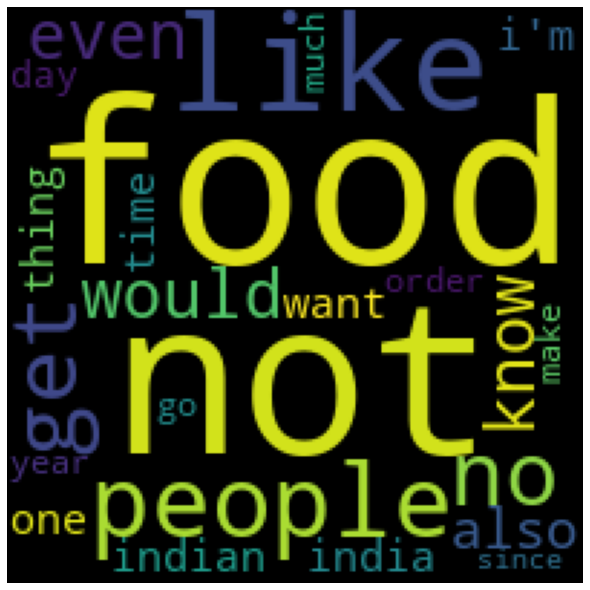

For Flair  AMA


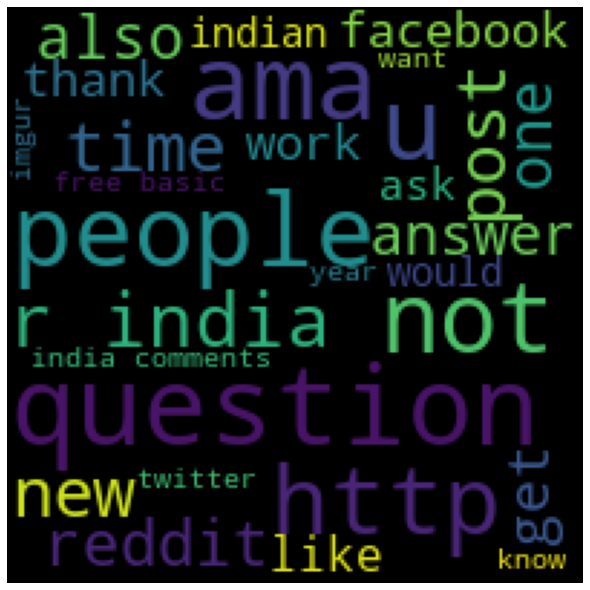

For Flair  Coronavirus


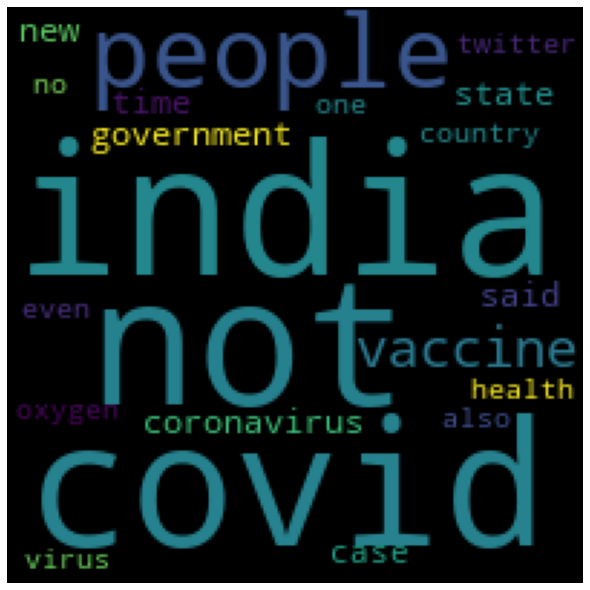

For Flair  CAA-NRC-NPR


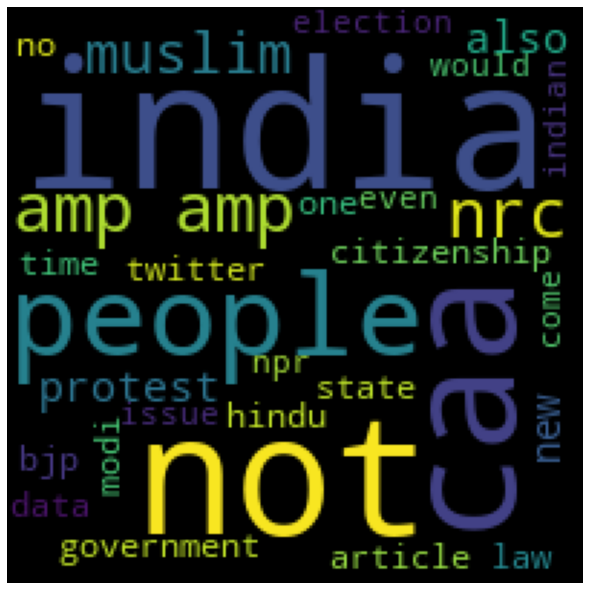

In [31]:
for i in flairs:
    print("For Flair ", i)
    a=df[df['flair']==i]
    
    comment_words = '' 
#     stopwords = set(STOPWORDS) 

    # iterate through the csv file 
    for val in a.body: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "
    wordcloud = WordCloud(width = 200, height = 200,  max_words=50,
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

### Top Words in comments for different flairs

For Flair  AskIndia


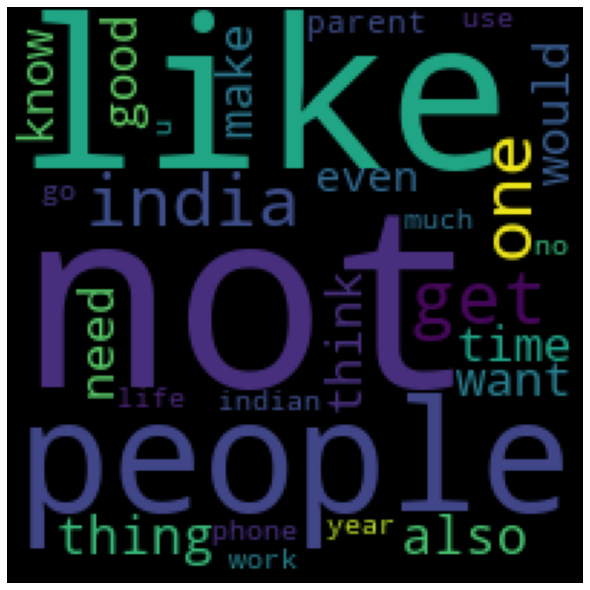

For Flair  Non-Political


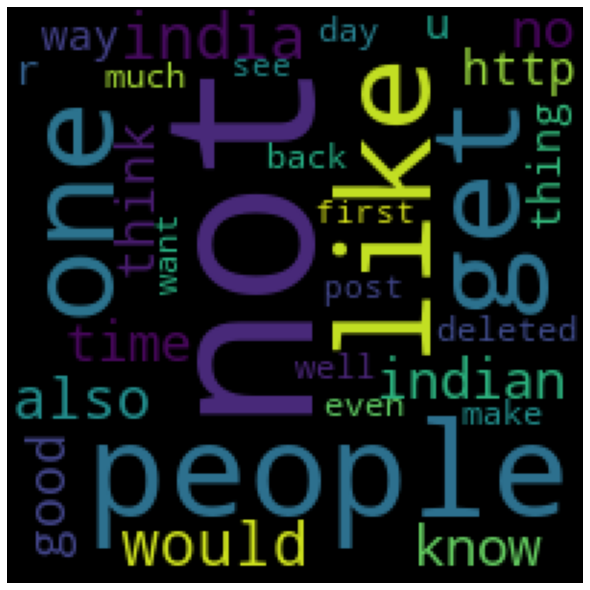

For Flair  [R]eddiquette


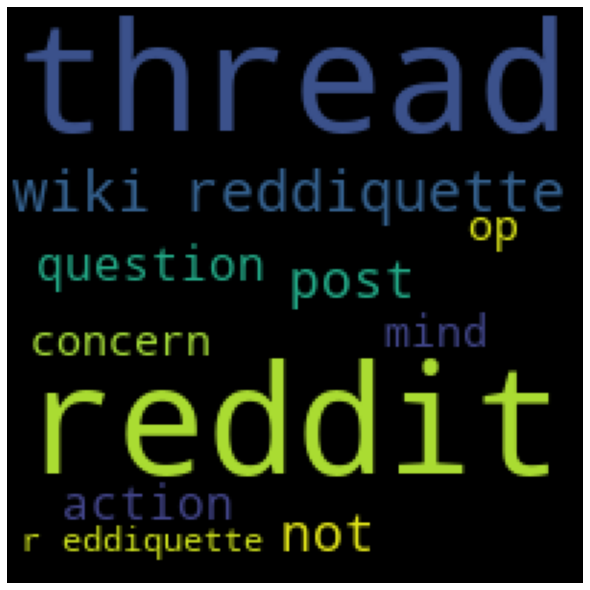

For Flair  Scheduled


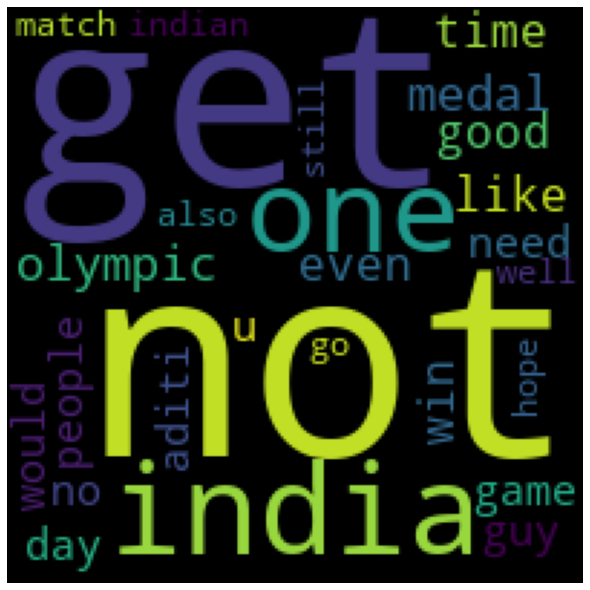

For Flair  Photography


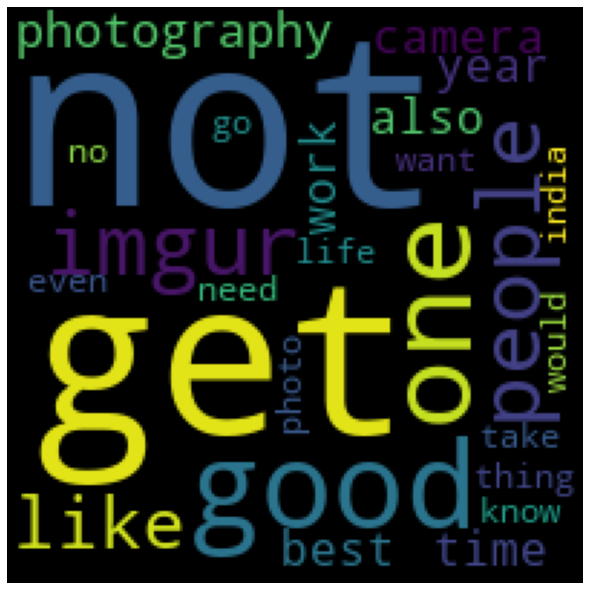

For Flair  Science/Technology


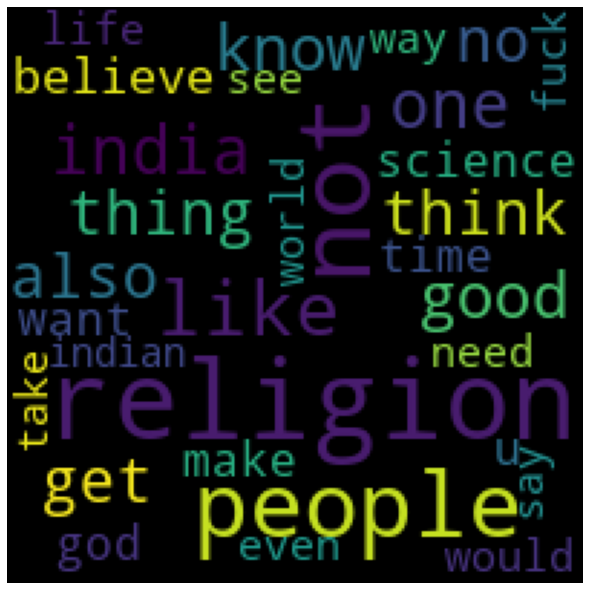

For Flair  Politics


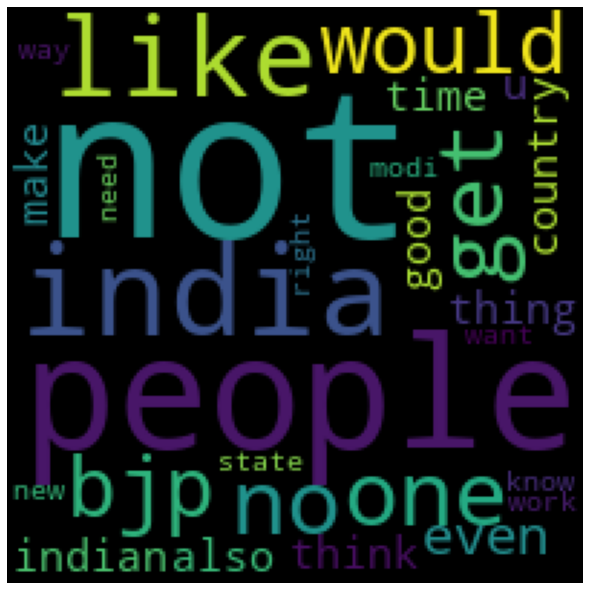

For Flair  Business/Finance


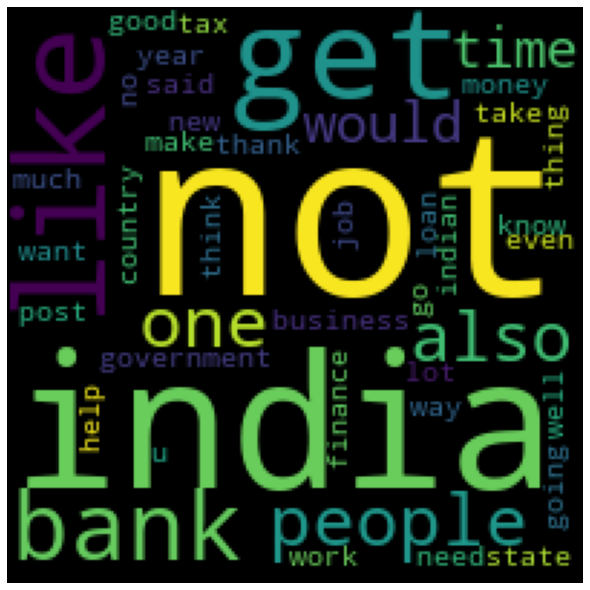

For Flair  Policy/Economy


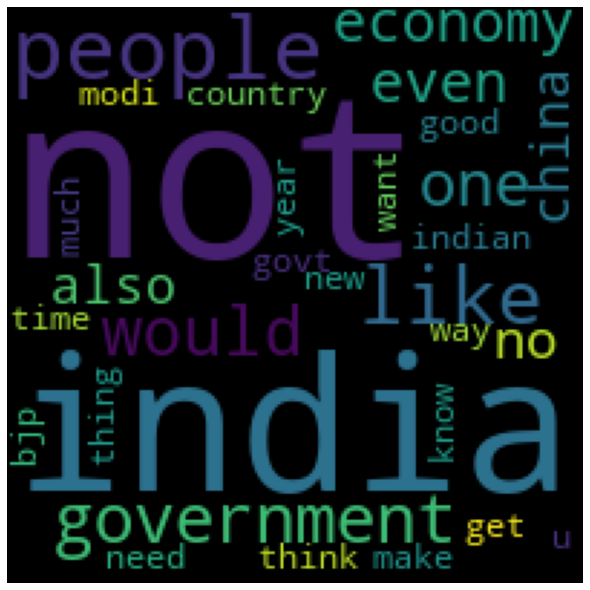

For Flair  Sports


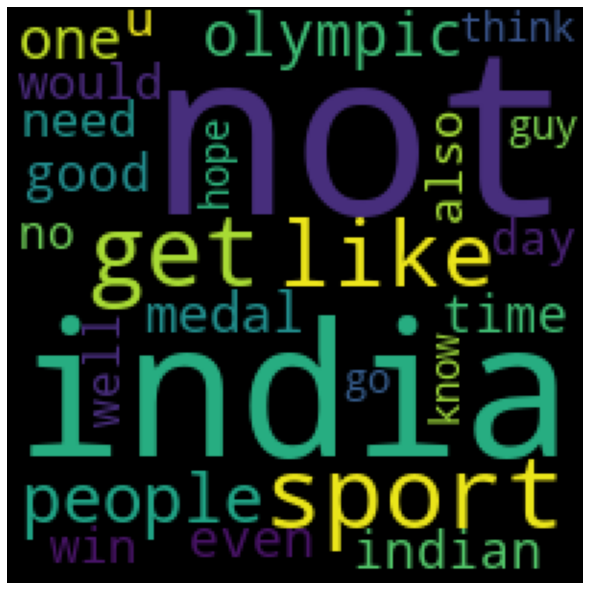

For Flair  Food


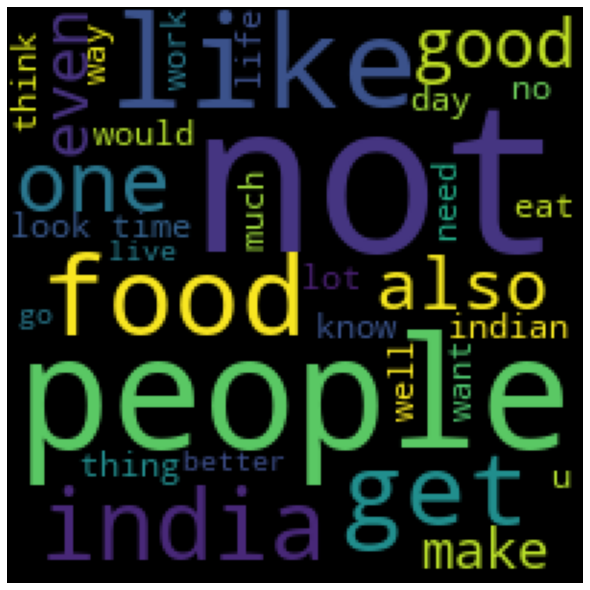

For Flair  AMA


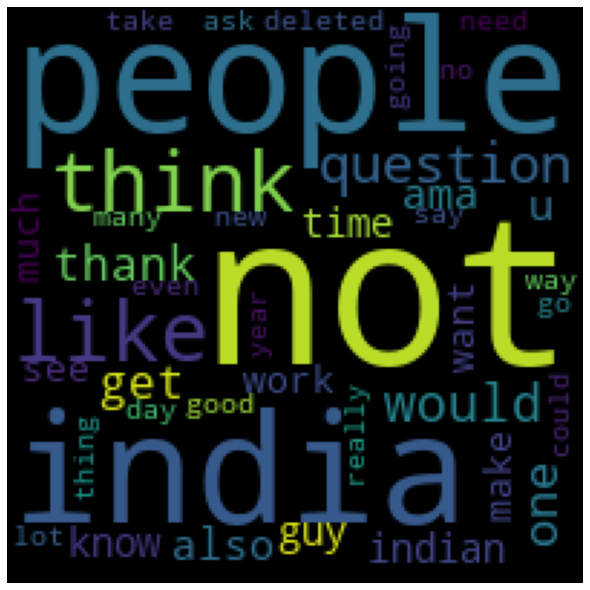

For Flair  Coronavirus


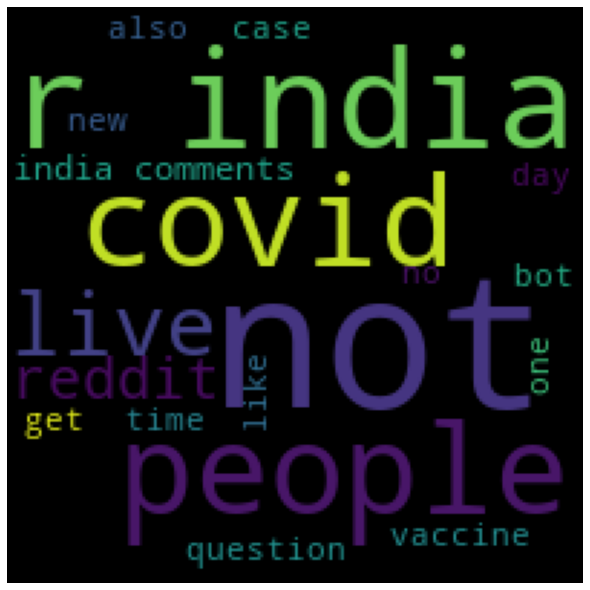

For Flair  CAA-NRC-NPR


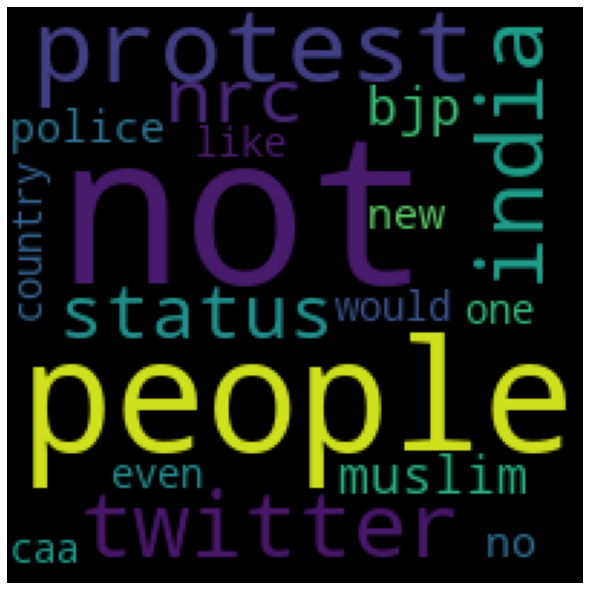

In [32]:
for i in flairs:
    print("For Flair ", i)
    a=df[df['flair']==i]
    
    comment_words = '' 
#     stopwords = set(STOPWORDS) 

    # iterate through the csv file 
    for val in a.comments: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "
    wordcloud = WordCloud(width = 200, height = 200,  max_words=50,
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

### Data Cleaning
1. Cell below prepares data so that special characters could be removed

In [33]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


### Cell below combines all forms of text data

In [34]:
df["Text"] = df["title"].map(str) + df["body"].map(str) + df["comments"].map(str) 

In [35]:
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 2791/2791 [00:07<00:00, 388.12it/s]


In [59]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
y=df['flair'][:]
# y = preprocessing.label_binarize(y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
X=preprocessed_reviews[:]

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=42)
bow = CountVectorizer(max_features=40000)
X_train_bow=bow.fit_transform(X_train)
X_test_bow=bow.transform(X_test)
print(X_train_bow.shape, y_train.shape)

(1953, 40000) (1953,)


In [60]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators = 1000, random_state = 42)

clf.fit(X_train_bow, y_train)
y_pred = clf.predict(X_test_bow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=flairs))

accuracy 0.7673031026252983
                    precision    recall  f1-score   support

          AskIndia       0.70      0.87      0.77        75
     Non-Political       0.79      0.55      0.65        47
     [R]eddiquette       0.69      0.75      0.72        73
         Scheduled       0.90      0.90      0.90        21
       Photography       0.91      0.89      0.90        71
Science/Technology       0.75      0.82      0.78        71
          Politics       0.83      0.83      0.83        65
  Business/Finance       0.83      0.88      0.85        65
    Policy/Economy       0.68      0.68      0.68        68
            Sports       0.64      0.72      0.68        65
              Food       0.90      0.62      0.74        74
               AMA       0.75      0.74      0.75        62
       Coronavirus       0.78      0.76      0.77        74
       CAA-NRC-NPR       0.83      0.71      0.77         7

          accuracy                           0.77       838
         m

In [61]:
def fit_rf(X, y):
    regressor = RandomForestClassifier(random_state=123, n_jobs=-1, n_estimators=1000)
    params = {'max_features' : ['auto','sqrt' , 'log2'],}
    grid = GridSearchCV(regressor, params, scoring='neg_mean_squared_error', cv=5)

    grid_fit = grid.fit(X_train_bow, y_train)

    return grid_fit.best_estimator_

# Fit the training data to the model using grid search
model = fit_rf(X_train_bow, y_train)

# Produce the value for 'n_estimators', 'max_depth', 'min_samples_split' and 'min_samples_leaf'
print(model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}


In [68]:
gst=RandomForestClassifier(bootstrap= True, ccp_alpha= 0.0, criterion= 'gini', max_features= 'auto', min_impurity_decrease= 0.0, min_samples_leaf= 1, min_samples_split= 2, min_weight_fraction_leaf= 0.0, n_estimators= 1000, n_jobs= -1, oob_score=True,random_state=123, verbose= 1, warm_start= False)



In [69]:
gst.fit(X_train_bow, y_train)
y_pred = gst.predict(X_test_bow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=flairs))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   42.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.9s finished


accuracy 0.7768496420047732
                    precision    recall  f1-score   support

          AskIndia       0.68      0.87      0.76        75
     Non-Political       0.81      0.55      0.66        47
     [R]eddiquette       0.77      0.77      0.77        73
         Scheduled       0.91      0.95      0.93        21
       Photography       0.91      0.90      0.91        71
Science/Technology       0.73      0.82      0.77        71
          Politics       0.82      0.85      0.83        65
  Business/Finance       0.84      0.89      0.87        65
    Policy/Economy       0.71      0.71      0.71        68
            Sports       0.63      0.69      0.66        65
              Food       0.89      0.64      0.74        74
               AMA       0.79      0.77      0.78        62
       Coronavirus       0.78      0.76      0.77        74
       CAA-NRC-NPR       0.83      0.71      0.77         7

          accuracy                           0.78       838
         m

In [72]:
joblib.dump(gst, 'random_forest_gs.pkl')

['random_forest_gs.pkl']

In [71]:
import joblib